## Make the four panel $\sigma_{in}$, $\sigma_{out}$ plot

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DER, model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = AggregateCheckpoints()

In [22]:
def normalize(inputs, outputs, normalization_params):
    inputmin = normalization_params["inputmin"]
    inputmax = normalization_params["inputmax"]
    inputs = (inputs - inputmin) / (inputmax - inputmin)
    outputmin = normalization_params["outputmin"]
    outputmax = normalization_params["outputmax"]
    outputs = (outputs - outputmin) / (outputmax - outputmin)
    return inputs, outputs
def denormalize(normalized_inputs, normalized_outputs, normalization_params):
    inputmin = normalization_params["inputmin"]
    inputmax = normalization_params["inputmax"]
    inputs = normalized_inputs * (inputmax - inputmin) + inputmin
    outputmin = normalization_params["outputmin"]
    outputmax = normalization_params["outputmax"]
    outputs = normalized_outputs * (outputmax - outputmin) + outputmin
    return inputs, outputs

linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
DE this is the mean true value 18.352034673268257
this is the mean predicted value 174.39001
this is the mean y_pred[:, 1] so variance 2.0784311
this is the mean u_al value 1.4220824
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_medium_beta_0.5_nmodel_0_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_0D_noise_high_beta_0.5_nmodel_0_epoch_99_sizedf_1000.pt
linear_homoskedastic simulation data generated,                 with noise injected type: predictive.
DER this is the mean true value 18.352034673268257
this is the mean predicted value 194.34523
this is the mean u_al value 3.2568526
cannot find this model ../DeepUQResources/checkpoints/DER_linear_homoskedastic_predictive_0D_noise_medium_loss_DER_COEFF_0.01_epoch_99_sizedf_1000.pt
linear_homoskedastic simulation data ge

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_79336/3936651354.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df[key] = torch.tensor(value)


DE this is the mean true value 0.04985802130793837
this is the mean predicted value 50.24619
this is the mean y_pred[:, 1] so variance 12.085854
this is the mean u_al value 2.995986
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_medium_beta_0.5_nmodel_0_epoch_99_sizedf_1000.pt
cannot find this model ../DeepUQResources/checkpoints/DE_linear_homoskedastic_predictive_2D_noise_high_beta_0.5_nmodel_0_epoch_99_sizedf_1000.pt
DER this is the mean true value 0.04985802130793837
this is the mean predicted value 48.38187
this is the mean u_al value 2.3359883
DER this is the mean true value 0.04985802130793837
this is the mean predicted value 0.4558005
this is the mean u_al value 0.013062937
DER this is the mean true value 0.04985802130793837
this is the mean predicted value 50.297836
this is the mean u_al value 8.002315
DE this is the mean true value 0.049790867549174785
this is the mean predicted value 55.939857
this is the mean y_pred[:, 1] so

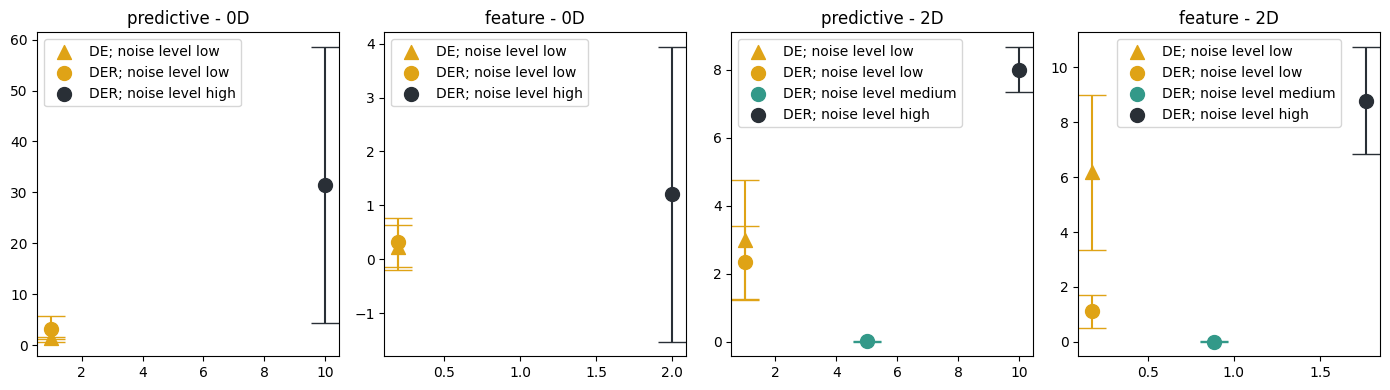

In [52]:
prescription = "linear_homoskedastic"
inject_type_list = ["predictive", "feature"]
data_dim_list = ["0D", "2D"]
model_type = ["DE", "DER"]
noise_list = ["low", "medium", "high"]
# these are the three colors for the three noise levels
color_list = ["#DFA316", "#339989", "#292F36"]
size_df = 1000
epoch = 99
fig, axes = plt.subplots(1, 4, figsize=(14, 4))  
axes = axes.flatten()
index = 0

# Iterate over the combinations of the two lists
for j, dim in enumerate(data_dim_list):
    for i, inject_type in enumerate(inject_type_list):
        ax = axes[index]
        ax.set_title(f'{inject_type} - {dim}')
        index += 1
        # first go through the two different model types
        for m, model in enumerate(model_type):
            for n, noise in enumerate(noise_list):
                sigma = DataPreparation.get_sigma(
                    noise, inject_type=inject_type, data_dimension=dim)
                # print(f"dim is {dim}, noise is {noise}, sigma is {sigma}, inject is {inject_type}")
                path = "../DeepUQResources/checkpoints/"
                if model == "DE":
                    loss = "bnll_loss"
                    nmodel = 0
                    BETA = 0.5
                    file_name = (
                        str(path) +
                        f"{model}_{prescription}_{inject_type}_{dim}"
                        f"_noise_{noise}_beta_{BETA}_nmodel_{nmodel}_epoch_{epoch}"
                    )
                    file_name += f"_sizedf_{size_df}"
                    file_name += ".pt"
                if model == "DER":
                    loss = "DER"
                    COEFF = 0.01
                    file_name = (
                        str(path)
                        + f"{model}_{prescription}_{inject_type}_{dim}"
                        + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
                    )
                    file_name += f"_sizedf_{size_df}"
                    file_name += ".pt"
                try:
                    chk = torch.load(file_name, map_location=DEVICE)
                except FileNotFoundError:
                    print("cannot find this model", file_name)
                    continue
                # set up the model and then load the checkpoint
                if model == "DER":
                    setupmodel, lossFn = model_setup_DER(
                        model, DEVICE, n_hidden=64, data_type=dim)
                elif model == "DE":
                    setupmodel, lossFn = model_setup_DE(
                        "bnll_loss", DEVICE, n_hidden=64, data_type=dim)
                # define the model at this epoch
                setupmodel.load_state_dict(chk.get("model_state_dict"))
                # checkpoint['model_state_dict'])
                setupmodel.eval()
                
                data = DataPreparation()
                
                if dim == "0D":
                    data.sample_params_from_prior(size_df)
                    data.simulate_data(
                        data.params,
                        sigma,
                        "linear_homoskedastic",
                        inject_type=inject_type,
                        seed=41,
                    )
                    df_array = data.get_dict()
                    # Convert non-tensor entries to tensors
                    df = {}
                    for key, value in df_array.items():
                
                        if isinstance(value, TensorDataset):
                            # Keep tensors as they are
                            df[key] = value
                        else:
                            # Convert lists to tensors
                            df[key] = torch.tensor(value)
                    len_df = len(df["params"][:, 0].numpy())
                    len_x = np.shape(df["output"])[1]
                    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
                    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
                    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
                    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
                
                    inputs = np.array([xs_array, ms_array, bs_array]).T
                    model_inputs = inputs
                    model_outputs = ys_array
                elif dim == "2D":
                    data.sample_params_from_prior(
                        size_df,
                        low=[0, 1, -1.5],
                        high=[0.5, 10, 1.5],
                        n_params=3,
                        seed=41)
                    model_inputs, model_outputs = data.simulate_data_2d(
                        size_df,
                        data.params,
                        image_size=32,
                        inject_type=inject_type,
                        sigma=sigma)
                x_test = model_inputs
                y_test = model_outputs
                
                #inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
                #_, norm_sigma = normalize(x_test, sigma, chk.get("norm_params"))
                #continue
                y_pred = setupmodel(
                    torch.Tensor(x_test
                        )
                    ).detach().numpy()
                # now take this and denorm
                # _, y_pred = denormalize(inputs_test, y_pred_normed, chk.get("norm_params"))
                if model == "DER":
                    print('DER this is the mean true value', np.mean(x_test))
                    print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                    beta = y_pred[:, 3]
                    nu = y_pred[:, 1]
                    alpha = y_pred[:, 2]
                    u_al = np.sqrt(
                        abs(
                        beta
                        * (1 + nu)
                        / (alpha * nu)
                        )
                    )
                    print('this is the mean u_al value', np.mean(u_al))
                    # now standardize the output uncertainty
                    # _, u_al_denormed = denormalize(x_test, u_al, chk.get("norm_params"))
                    ax.errorbar(
                            sigma,
                            np.mean(u_al),
                            yerr = np.std(u_al),
                            color=color_list[n],
                            capsize=10
                        )
                    ax.scatter(
                            sigma,
                            np.mean(u_al),
                            color=color_list[n],
                            label=f"DER; noise level {noise}",
                            s=100
                        )
                elif model == "DE":
                    print('DE this is the mean true value', np.mean(x_test))
                    print('this is the mean predicted value', np.mean(y_pred[:, 0]))
                    u_al = np.sqrt(y_pred[:, 1])
                    print('this is the mean y_pred[:, 1] so variance', np.mean(y_pred[:, 1]))
                    print('this is the mean u_al value', np.mean(u_al))
                    ax.errorbar(
                            sigma,
                            np.mean(u_al),
                            yerr = np.std(u_al),
                            color=color_list[n],
                            capsize=10
                        )
                    ax.scatter(
                            sigma,
                            np.mean(u_al),
                            color=color_list[n],
                            label=f"DE; noise level {noise}",
                            s=100,
                            marker="^"
                        )
                ax.legend()
plt.tight_layout()
plt.show()
#plt.savefig('../../../Desktop/validation_DER.png', dpi=1000)

In [ ]:
size_df = 1000
data = DataPreparation()
sigma = DataPreparation.get_sigma(
        noise_level, inject_type=inject_type, data_dimension=dim)
print(f"noise is {noise_level}, sigma is {sigma}")
if dim == "0D":
    data.sample_params_from_prior(size_df)
    data.simulate_data(
        data.params,
        sigma,
        "linear_homoskedastic",
        inject_type=inject_type,
        seed=41,
    )
    df_array = data.get_dict()
    # Convert non-tensor entries to tensors
    df = {}
    for key, value in df_array.items():

        if isinstance(value, TensorDataset):
            # Keep tensors as they are
            df[key] = value
        else:
            # Convert lists to tensors
            df[key] = torch.tensor(value)
    len_df = len(df["params"][:, 0].numpy())
    len_x = np.shape(df["output"])[1]
    ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
    bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
    xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
    ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))

    inputs = np.array([xs_array, ms_array, bs_array]).T
elif dim == "2D":
    data.sample_params_from_prior(
        size_df,
        low=[1, 1, -1.5],
        high=[10, 10, 1.5],
        n_params=3,
        seed=41)
    model_inputs, model_outputs = data.simulate_data_2d(
        size_df,
        data.params,
        image_size=32,
        inject_type=inject_type,
        sigma=sigma)

_, x_test, _, y_test = DataPreparation.train_val_split(
    model_inputs, model_outputs, val_proportion=0.1,
    random_state=41
)

In [ ]:
chk.get("norm_params")

In [ ]:
def normalize(inputs, outputs, normalization_params):
    inputmin = normalization_params["inputmin"]
    inputmax = normalization_params["inputmax"]
    inputs = (inputs - inputmin) / (inputmax - inputmin)
    outputmin = normalization_params["outputmin"]
    outputmax = normalization_params["outputmax"]
    outputs = (outputs - outputmin) / (outputmax - outputmin)
    return inputs, outputs

In [ ]:
inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))

In [ ]:
y_pred = DERmodel(
    torch.Tensor(inputs_test
        )
    ).detach().numpy()

In [ ]:
# Create a figure with 5 subplots in a horizontal row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust the figsize as needed

# Loop through each subplot
for i in range(5):
    ax = axes[i]
    ax.imshow(inputs_test[i, :, :], aspect='auto')
    ax.set_title(f'true = {round(outputs_test[i],2)}, pred = {round(y_pred[i,0],2)}')
    ax.figure.colorbar(ax.images[0], ax=ax)
    ax.set_aspect('equal')

# Show the complete figure
plt.tight_layout()
plt.savefig(f'../../../Desktop/validation_DER_{noise_level}_{inject_type}_{dim}.png', dpi=1000)

In [ ]:
plt.scatter(
            outputs_test,
            y_pred[:, 0],
            #color=color_list[i],
            #label=r"$\sigma = $" + str(sigma_list[i]),
            s=3,
        )
plt.xlabel('true value')
plt.ylabel('predicted value');

Also create a way to overplot all three models at once, or perhaps plot three subplots?

NameError: name 'noise_level' is not defined

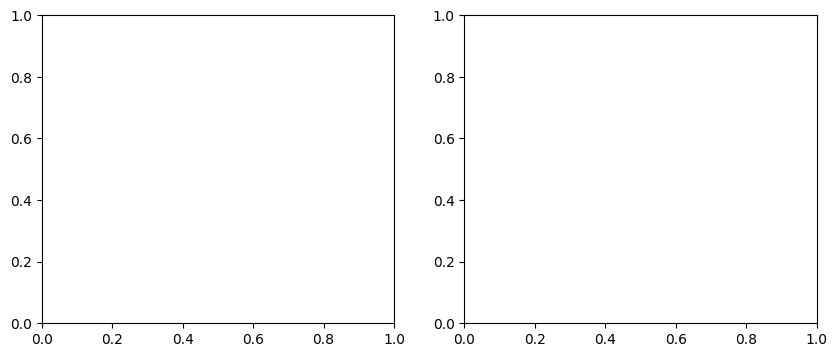

In [10]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise_level}, sigma is {sigma}")
        chk = checkpoints.load_checkpoint(
            "DER",
            "linear_homoskedastic",
            inject_type,
            dim,
            noise,
            99,
            DEVICE,
            path="../DeepUQResources/checkpoints/",
            loss="DER",
            COEFF=0.01
        )
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 1000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        print('model outputs after normalization', outputs_test[0])
        #continue
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                y_pred[:, 0],
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].plot([0,1],[0,1], ls='--', color='grey')
    axes[j].set_xlabel('true value')
    axes[j].set_ylabel('predicted value')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.savefig('../../../Desktop/validation_DER.png', dpi=1000)

Now look at residuals. (pred - true)

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise_level}, sigma is {sigma}")
        chk = checkpoints.load_checkpoint(
            "DER",
            "linear_homoskedastic",
            inject_type,
            dim,
            noise,
            99,
            DEVICE,
            path="../DeepUQResources/checkpoints/",
            loss="DER",
            COEFF=0.01
        )
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 1000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.savefig('../../../Desktop/residual_DER.png', dpi=1000)

## Look into if 10k images is necessary or if we can run with 1k.
I added a feature to 

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    # noise_list = ["high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 1000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('1k training set')
#plt.show()
plt.savefig('../../../Desktop/residual_DER_1k.png', dpi=1000)

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 10000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('10k training set')
#plt.show()
plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

## Also show error bars to put the residuals in context

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low"]#, "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 10000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs
        '''
        _, x_test, _, y_test = DataPreparation.train_val_split(
            model_inputs, model_outputs, val_proportion=0.1,
            random_state=41
        )
        '''
        inputs_test, outputs_test = normalize(x_test, y_test, chk.get("norm_params"))
        y_pred = DERmodel(
            torch.Tensor(inputs_test
                )
            ).detach().numpy()
        beta = y_pred[:, 3]
        nu = y_pred[:, 1]
        alpha = y_pred[:, 2]
        u_al = np.sqrt(
            beta
            * (1 + nu)
            / (alpha * nu)
        )
        axes[j].errorbar(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                yerr=u_al,
                color=color_list[i],
            )
        axes[j].scatter(
                outputs_test,
                (y_pred[:, 0] - outputs_test), # / outputs_test,
                color=color_list[i],
                edgecolor='black',
                label=r"$\sigma_x = $" + str(round(sigma,2)),
                s=5,
                zorder=100
            )
    axes[j].axhline(y=0, ls='--', color='grey')
    axes[j].set_xlabel('true value')
    if j == 0:
        axes[j].set_ylabel('residual (predicted - true)') #/ true')
    axes[j].set_title(inject_type)
    axes[j].legend() 
plt.suptitle('10k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

## Another question I have is whether the test set is somehow misaligned with the training / validation set.

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low"]#, "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss = "DER"
        COEFF = 0.01
        epoch = 99
        size_df = 10000
        file_name = (
            str(path)
            + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
            + f"_noise_{noise}_loss_{loss}_COEFF_{COEFF}_epoch_{epoch}"
        )
        file_name += f"_sizedf_{size_df}"
        file_name += ".pt"
        try:
            chk = torch.load(file_name, map_location=DEVICE)
        except FileNotFoundError:
            continue
        # set up the model and then load the checkpoint
        DERmodel, lossFn = model_setup_DER(
            "DER", DEVICE, n_hidden=64, data_type=dim)
        # define the model at this epoch
        DERmodel.load_state_dict(chk.get("model_state_dict"))
        # checkpoint['model_state_dict'])
        DERmodel.eval()
        size_df = 10000
        data = DataPreparation()

        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=42,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=42)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_train = model_inputs
        y_train = model_outputs
        
        if dim == "0D":
            data.sample_params_from_prior(size_df)
            data.simulate_data(
                data.params,
                sigma,
                "linear_homoskedastic",
                inject_type=inject_type,
                seed=41,
            )
            df_array = data.get_dict()
            # Convert non-tensor entries to tensors
            df = {}
            for key, value in df_array.items():
        
                if isinstance(value, TensorDataset):
                    # Keep tensors as they are
                    df[key] = value
                else:
                    # Convert lists to tensors
                    df[key] = torch.tensor(value)
            len_df = len(df["params"][:, 0].numpy())
            len_x = np.shape(df["output"])[1]
            ms_array = np.repeat(df["params"][:, 0].numpy(), len_x)
            bs_array = np.repeat(df["params"][:, 1].numpy(), len_x)
            xs_array = np.reshape(df["inputs"].numpy(), (len_df * len_x))
            ys_array = np.reshape(df["output"].numpy(), (len_df * len_x))
        
            inputs = np.array([xs_array, ms_array, bs_array]).T
        elif dim == "2D":
            data.sample_params_from_prior(
                size_df,
                low=[1, 1, -1.5],
                high=[10, 10, 1.5],
                n_params=3,
                seed=41)
            model_inputs, model_outputs = data.simulate_data_2d(
                size_df,
                data.params,
                image_size=32,
                inject_type=inject_type,
                sigma=sigma)
        
        x_test = model_inputs
        y_test = model_outputs

        plt.clf()
        plt.hist(y_test, label='test', alpha=0.5)
        plt.hist(y_train, label='train', alpha=0.5)
        plt.legend()
        plt.show()
        print(np.shape(x_test))
        plt.clf()
        plt.hist(x_test.flatten(), label='test', alpha=0.5)
        plt.hist(x_train.flatten(), label='train', alpha=0.5)
        plt.legend()
        plt.show()
        

## I'd also like to plot loss for all of these training runs.

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 1000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('1k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)

In [ ]:
inject_type_list = ["predictive", "feature"]
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for j, inject_type in enumerate(inject_type_list):
    noise_list = ["low", "medium", "high"]
    color_list = ["#DFA316", "#339989", "#292F36"]
    for i, noise in enumerate(noise_list):
        sigma = DataPreparation.get_sigma(
            noise, inject_type=inject_type, data_dimension=dim)
        print(f"noise is {noise}, sigma is {sigma}")
        path = "../DeepUQResources/checkpoints/"
        model_name = "DER"
        prescription = "linear_homoskedastic"
        data_dim = "2D"
        loss_name = "DER"
        COEFF = 0.01
        size_df = 10000
        n_epochs = 100
        mse_loss = []
        loss = []
        train_mse_loss = []
        train_loss = []
        for epoch in range(n_epochs):
            file_name = (
                str(path)
                + f"{model_name}_{prescription}_{inject_type}_{data_dim}"
                + f"_noise_{noise}_loss_{loss_name}_COEFF_{COEFF}_epoch_{epoch}"
            )
            file_name += f"_sizedf_{size_df}"
            file_name += ".pt"
            chk = torch.load(file_name, map_location=DEVICE)
            mse_loss.append(chk["valid_mse"])
            loss.append(chk["valid_loss"])
            train_mse_loss.append(chk["train_mse"])
            train_loss.append(chk["train_loss"])
        print('j', j)
        axes[j].plot(
                range(n_epochs),
                train_mse_loss,
                color=color_list[i],
                label=r"Training MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j].plot(
                range(n_epochs),
                mse_loss,
                color=color_list[i],
                label=r"Validation MSE loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                train_loss,
                color=color_list[i],
                label=r"Training NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                #s=5,
            )
        axes[j+2].plot(
                range(n_epochs),
                loss,
                color=color_list[i],
                label=r"Validation NIG loss; $\sigma_x = $" + str(round(sigma,2)),
                ls = '--'
                #s=5,
            )
        
    
    if j == 0:
        axes[j].set_ylabel('MSE loss') #/ true')
        axes[j+2].set_ylabel('NIG loss')
    axes[j].set_title(inject_type)
    axes[j].legend() 
axes[2].set_xlabel('epoch')
axes[3].set_xlabel('epoch')
plt.suptitle('10k training set')
plt.show()
#plt.savefig('../../../Desktop/residual_DER_10k.png', dpi=1000)